In [48]:
import numpy as np
import pandas as pd
import sqlite3 as sq
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression,  Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
import random
import warnings
warnings.filterwarnings('ignore')


In [49]:
with gzip.open('compensation_cpi.csv.gz', 'rb') as f:
    df2= pd.read_csv(f)
#df2.head()

In [50]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466589 entries, 0 to 1466588
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   year                1466589 non-null  int64  
 1   department          1466587 non-null  object 
 2   job_title           1466043 non-null  object 
 3   base_salary         1465890 non-null  float64
 4   overtime            1433207 non-null  float64
 5   irregular_cash      1466155 non-null  float64
 6   total_cash          1466589 non-null  float64
 7   retirement          1466589 non-null  float64
 8   health              1447602 non-null  float64
 9   other_benefits      830557 non-null   float64
 10  total_benefits      1466589 non-null  float64
 11  total_compensation  1466589 non-null  float64
 12  city_id             1466589 non-null  int64  
 13  annual_average_cpi  1466589 non-null  float64
 14  inflation_rate      1466589 non-null  float64
dtypes: float64(11),

##  Check for duplicates

In [51]:
#Count the number of duplicates
num_duplicates = df2.duplicated().sum()
num_duplicates
# #view duplicate rows
# duplicate_row = df[df.duplicated()]
# duplicate_row.head()

27904

In [52]:
# drop duplicates and reset index
df2 = df2.drop_duplicates().reset_index(drop=True)
df2.shape

(1438685, 15)

## Check for missing data

In [53]:
# Check missing data
df2.isnull().sum()

year                       0
department                 2
job_title                446
base_salary              680
overtime               33113
irregular_cash           406
total_cash                 0
retirement                 0
health                 18833
other_benefits        618294
total_benefits             0
total_compensation         0
city_id                    0
annual_average_cpi         0
inflation_rate             0
dtype: int64

#### --> The null values in compensation columns could be due to the fact that those values are not applicable such as people did not have overtime work, or contractors that might not subject to compensation. It is safe to impute those missing value with 0 

In [54]:
#Impute missing value in salary an dcompensation with 0 value
df2[['overtime', 'irregular_cash' ,  'health', 'other_benefits']] = df2[[ 'overtime', 'irregular_cash' ,  'health', 'other_benefits']].fillna(0)
df2['job_title'] = df2['job_title'].fillna("Not disclosed")
df2['base_salary'] = df2['base_salary'].fillna((df2['total_cash'] - df2['overtime'] - df2['irregular_cash']))


In [55]:
#observe row with null values in department 
dep_null = df2[df2['department'].isnull()]
dep_null.head()

,year,department,job_title,base_salary,overtime,irregular_cash,total_cash,retirement,health,other_benefits,total_benefits,total_compensation,city_id,annual_average_cpi,inflation_rate
138816,2017,NaN,Sheriff's Cadet,49630.50,15016.51,3197.52,67844.53,10619.27,12779.88,4796.56,28195.71,96040.24,2,245.1,2.1
425621,2017,NaN,Police Officer 2,116189.62,40990.09,2260.08,159439.80,20076.66,14515.01,2724.05,37315.72,196755.52,2,245.1,2.1


In [56]:
#fill in the missing police department names
df2['department'].fillna('Police',inplace=True)

In [57]:
df2.isna().sum()
df2.isnull().sum()

year                  0
department            0
job_title             0
base_salary           0
overtime              0
irregular_cash        0
total_cash            0
retirement            0
health                0
other_benefits        0
total_benefits        0
total_compensation    0
city_id               0
annual_average_cpi    0
inflation_rate        0
dtype: int64

In [58]:
#Observe job title
df2['job_title'].nunique()

4175

In [59]:
unique_values2 = df2.groupby('city_id')['job_title'].nunique()
unique_values2

city_id
1     682
2    1360
3    2159
Name: job_title, dtype: int64

In [60]:
# unique_values = df.groupby('department')['job_title'].unique()

# # Print the unique values for each group
# for group, values in unique_values.items():
#     print(f"Group '{group}' has the following unique values in the 'column_name' column:")
#     print(values)
#     print()

#### --> there are almost 5000 job_titles which would be a challenge as a feature in modeling. In addition condensing is not an easy task, so we might have to drop it, therefore imputing missing data is not neccesary here.

## Condensing Department Names

In [61]:
def replace_text(text):
    if pd.isna(text) or text is None:
        return text
    elif target_word.lower() in text.lower():
        return new_word
    else:
        return text

In [62]:
target_word= "Police"
new_word= "Police"
df2['department'] = df2['department'].apply(replace_text)

In [63]:
dept_dict = {
    'Police': 'Police', 'Sheriff': 'Police', "Vcet" : "Police",   
    "Fire" : "Emergency Management",    "Emergency" : "Emergency Management",
    "PW" : "Public Works",    "Public" : "Public Works",    "Water" : "Public Works",    "DOT" : "Public Works",    "Transport" : "Public Works",
    "Plan" : "Public Works",    "Building" : "Public Works",    #"District" : "Public Works",    
    "PRNS" : "Parks",    "Recre" : "Parks",    "Zoo" : "Parks",    "Parks" : "Parks",    "Arena" : "Parks",
    "City" : "City Mgmt",    "Convention" : "City Mgmt",    "Neighbor" : "City Mgmt",    "Election" : "City Mgmt",    "Council" : "City Mgmt",
    "CII" : "City Mgmt",    "Clerk" : "City Mgmt",    "Registrar" : "City Mgmt",    "Housing" : "City Mgmt",    "Mayor" : "City Mgmt",    "rda" : "City Mgmt",
    "Airport" : "Airport",    "Airside" : "Airport",
    "Finance" : "Finance",    "Auditor" : "Finance",    "Assessor" : "Finance",    "Controller" : "Finance",    "Tax" : "Finance", "Treasure" : "Finance",
    "Board" : "Law and Reg",    "Attorney" : "Law and Reg",    "Court" : "Law and Reg",
    "Ethics" : "Law and Reg",    "Probation" : "Law and Reg",    "Regulation" : "Law and Reg",
    "prt" : "Port",    "port" : "Port", "Harbor" : "Port",
    "Human" : "Human Services",    "Retire" : "Human Services",    "Child" : "Human Services",    "Service" : "Human Services",
    "Personnel" : "Human Services",    "Aging" : "Human Services",    "Women" : "Human Services",    "Pension" : "Human Services",
    "Disability" : "Human Services",    "Families" : "Human Services", "Youth" : "Human Services",
    "ESD" : "Human Services",    "Employee" : "Human Services",
    "Info" : "IT",    "Tech" : "IT",
    "Envi" : "Energy, Env, Economy",    "Energy" : "Energy, Env, Economy",    "Power" : "Energy, Env, Economy", "Econ" : "Energy, Env, Economy",
    "Science" : "Libraries, Arts, Science, Museums",    "Librar" : "Libraries, Arts, Science, Museums",    "Museum" : "Libraries, Arts, Science, Museums",
    "Memorial" : "Libraries, Arts, Science, Museums",    "Monument" : "Libraries, Arts, Science, Museums",    "Arts" : "Libraries, Arts, Science, Museums",
    "Cultur" : "Libraries, Arts, Science, Museums", "Art Commission" : "Libraries, Arts, Science, Museums"
}

In [64]:
for key in dept_dict:
    target_word= key
    new_word= dept_dict[key]
    df2['department'] = df2['department'].apply(replace_text)

In [65]:
df2['department'].unique()

array(['Parks', 'City Mgmt', 'Public Works', 'Finance', 'Law and Reg',
       'Port', 'Libraries, Arts, Science, Museums', 'Human Services',
       'Police', 'IT', 'Emergency Management', 'Energy, Env, Economy'],
      dtype=object)

## Summary Statistics and outliers

In [66]:
#Summary sttistics
df2.describe()

,year,base_salary,overtime,irregular_cash,total_cash,retirement,health,other_benefits,total_benefits,total_compensation,city_id,annual_average_cpi,inflation_rate
count,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06
mean,2.017060e+03,6.939467e+04,7.340716e+03,4.326823e+03,8.106693e+04,1.691722e+04,1.020891e+04,2.804429e+03,2.993055e+04,1.109975e+05,2.379948e+00,2.477668e+02,1.847782e+00
std,2.539337e+00,4.780912e+04,1.709815e+04,9.314511e+03,5.864736e+04,1.653596e+04,6.967392e+03,3.754897e+03,2.205499e+04,7.793299e+04,5.789799e-01,1.163875e+01,1.158377e+00
min,2.013000e+03,-6.877178e+04,-2.490362e+04,-6.908210e+04,-6.877178e+04,-5.869240e+04,-1.259245e+04,-1.063650e+04,-5.039960e+04,-7.408261e+04,1.000000e+00,2.330000e+02,1.000000e-01
25%,2.015000e+03,2.607120e+04,0.000000e+00,2.470000e+00,2.979432e+04,3.089360e+03,3.326620e+03,0.000000e+00,9.083400e+03,4.074871e+04,2.000000e+00,2.370000e+02,1.300000e+00
50%,2.017000e+03,6.940488e+04,9.560000e+01,1.285220e+03,7.790465e+04,1.450748e+04,1.243878e+04,5.029100e+02,3.114874e+04,1.102013e+05,2.000000e+00,2.451000e+02,1.600000e+00
75%,2.019000e+03,1.019360e+05,6.421260e+03,4.961200e+03,1.175153e+05,2.397671e+04,1.539537e+04,5.365810e+03,4.334440e+04,1.621956e+05,3.000000e+00,2.557000e+02,2.100000e+00
max,2.021000e+03,6.519367e+05,4.343939e+05,2.394972e+06,2.394972e+06,2.136775e+05,2.556148e+05,3.569104e+04,2.556148e+05,2.394972e+06,3.000000e+00,2.710000e+02,4.700000e+00


In [67]:
#Check rows with negative values
cols = ['base_salary', 'overtime', 'irregular_cash', 'total_cash',  'retirement', 'health',	'other_benefits', 'total_benefits',	'total_compensation', 'city_id']
negative_rows = df2[cols][(df2[cols] < 0).any(axis=1)]
negative_rows.head()

,base_salary,overtime,irregular_cash,total_cash,retirement,health,other_benefits,total_benefits,total_compensation,city_id
2985,144646.56,0.00,12521.65,157168.20,41550.49,17936.85,-239.02,59248.32,216416.53,2
4620,21792.19,-292.80,94.68,21594.07,0.00,0.00,1676.05,1676.05,23270.12,2
8231,119694.97,0.00,11084.23,130779.20,27239.17,15551.14,-189.99,42600.32,173379.52,2
9500,37013.00,193.93,-599.05,36607.88,10978.06,289.90,0.00,11267.96,47875.84,3
9788,163147.23,31827.60,-2665.12,192309.72,76434.48,18511.00,0.00,94945.48,287255.20,3


In [68]:
negative_rows.shape

(5882, 10)

#### --> there are negative values distributed randomly in most of the float type columns such as base_salary, overtime, etc. It doesn't seem to make sense why would someone working would get negative cash and negative benefit pay. There are roughly 6000 instances which is very small portion of the entire data, so we decided to drop these rows

In [69]:
#Drop those row with negative values
df2 = df2.drop(negative_rows.index).reset_index(drop=True)
df2.shape

(1432803, 15)

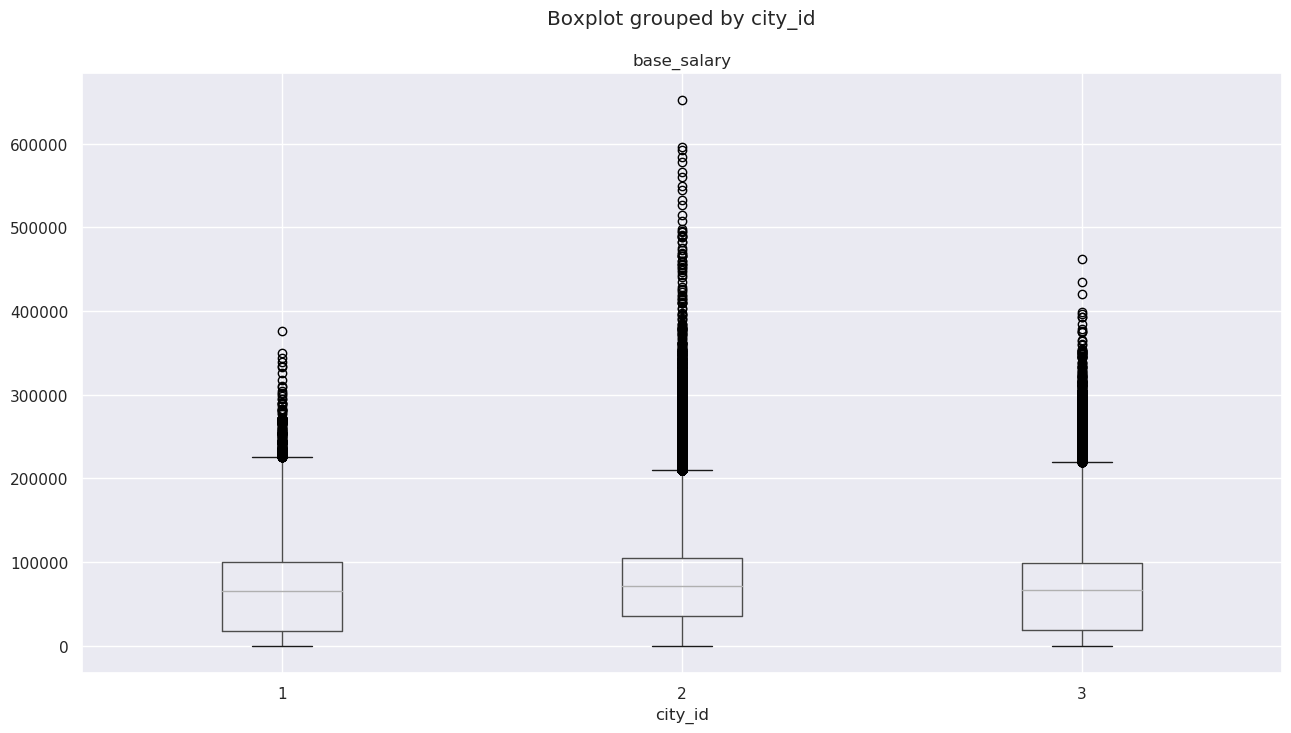

In [70]:
boxplot = df2.boxplot(column=['base_salary'], by='city_id')
plt.show()

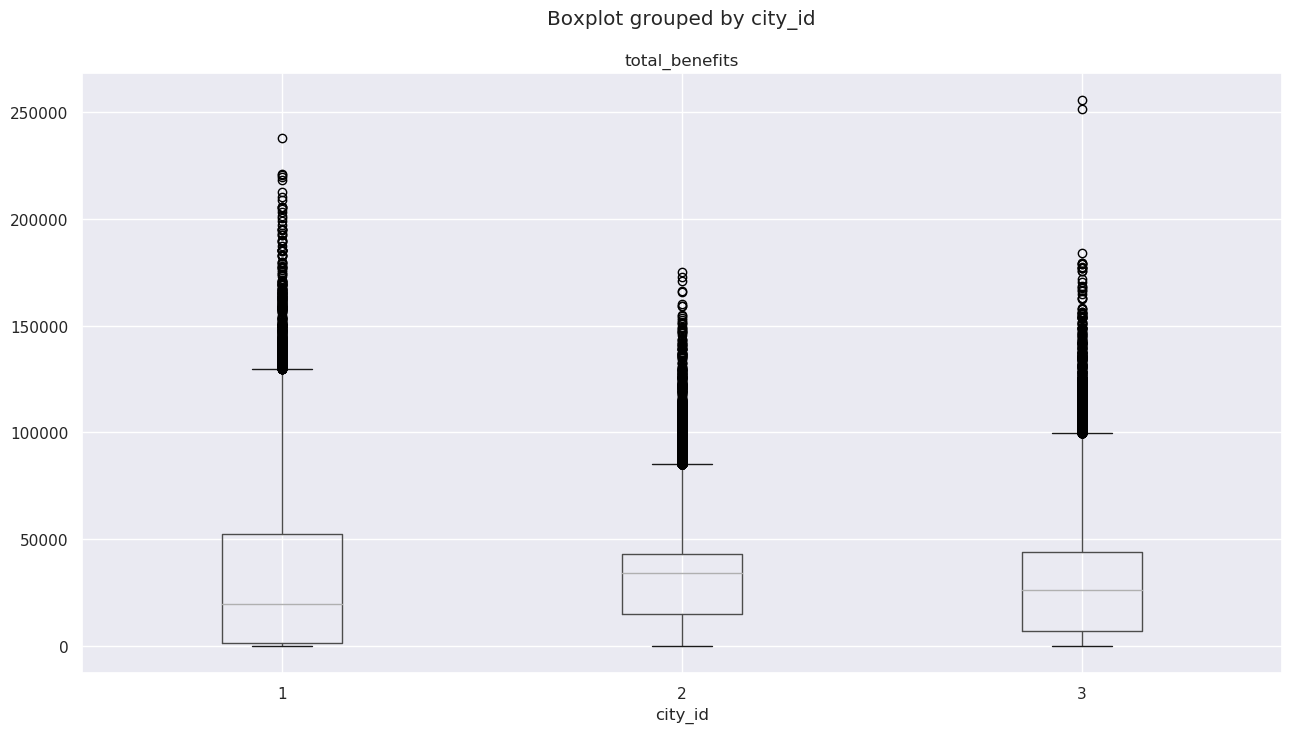

In [71]:
boxplot = df2.boxplot(column=['total_benefits'], by='city_id')
plt.show()

##  Examine Correlation and Feature Selection

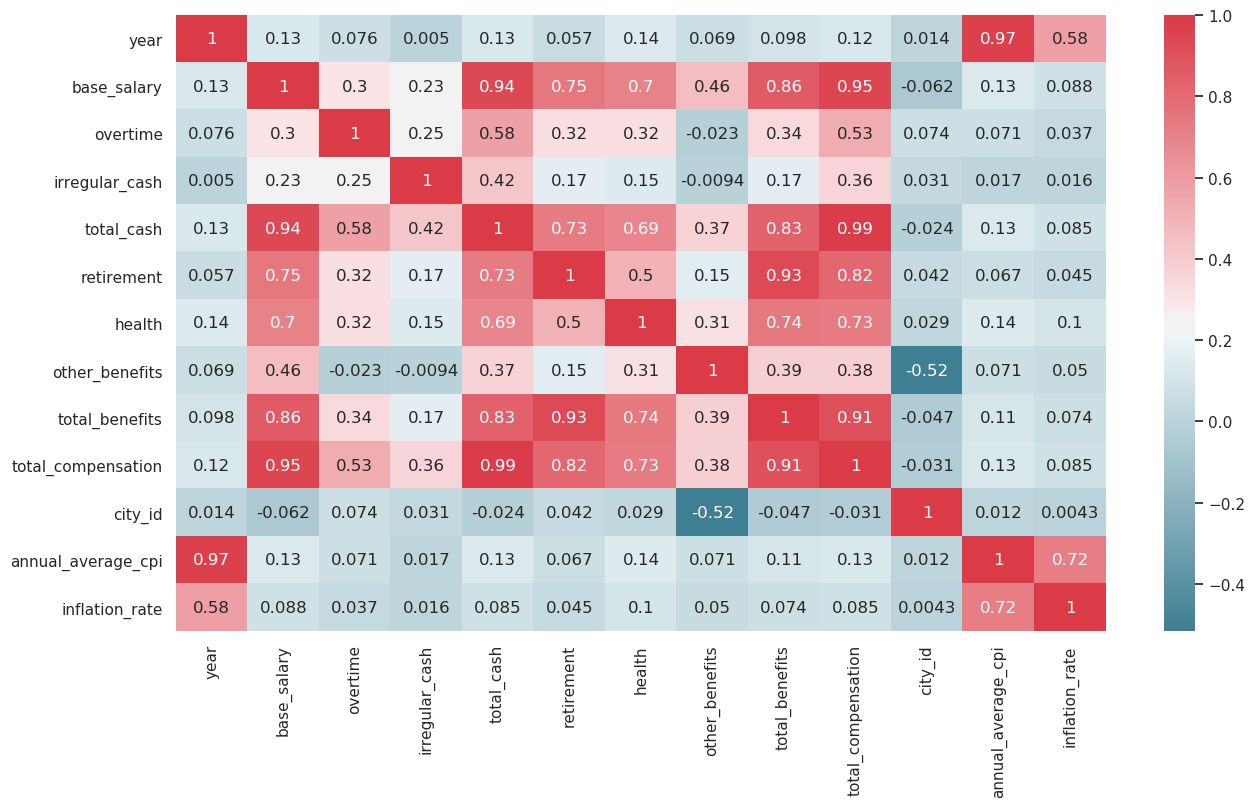

In [72]:
# plot the heatmap and annotation on it
#Correlation matrix 
corr_matrix = df2.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr_matrix, cmap=cmap, annot=True)
plt.show()

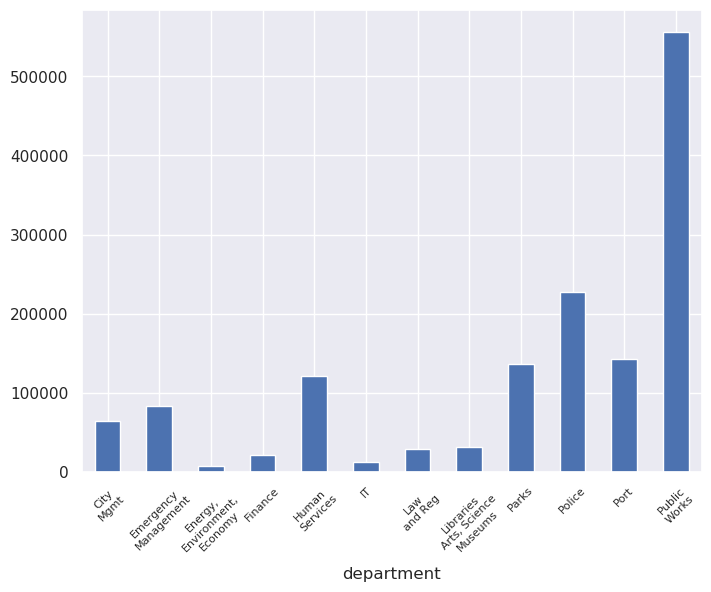

In [73]:
# group by 'category' and count the values in each group
counts = df2.groupby('department')['department'].count()

#Plot department distribution
fig, ax = plt.subplots(figsize=(8, 6))
counts.plot(kind='bar', ax=ax)
# break the tick labels into two lines
labels = ['City\nMgmt', 'Emergency\nManagement', 'Energy,\nEnvironment,\nEconomy', 
          'Finance', 'Human\nServices', 'IT', 'Law\nand Reg', 
          'Libraries\nArts, Science\nMuseums', 'Parks', 'Police', 'Port', 'Public\nWorks']
ax.set_xticklabels(labels, fontsize=8)
plt.xticks(rotation=45)
plt.show()

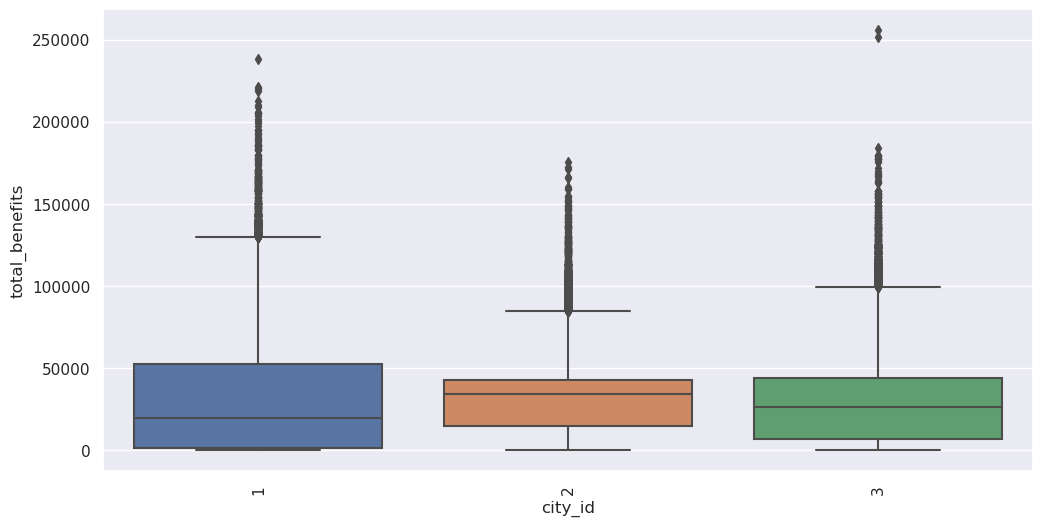

In [74]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df2,x='city_id',y='total_benefits')
plt.xticks(rotation=90)
plt.show()

In [75]:
#Examine columns with high correlation 
cor_matrix = df2.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),
                                     k=1).astype(bool))

high_corr = [column for column in upper_tri.columns if 
           any(upper_tri[column] > 0.75)]
print('These are the columns prescribed to be potentially dropped: %s'%high_corr)

These are the columns prescribed to be potentially dropped: ['total_cash', 'retirement', 'total_benefits', 'total_compensation', 'annual_average_cpi']


#### --> since total_benefits would be our target, so it would be kept. Annual_average_cpi is highly correlated with year, but Annual_average_cpi might be a better feature to reflect the anual economy which could affect the salary and benefit. 

In [76]:
#Drop columns
to_drop = ['job_title',  'total_cash',  'retirement',  'health', 'other_benefits', 'inflation_rate',  'total_compensation']
df3 = df2.drop(to_drop, axis=1)
df3.head()

,year,department,base_salary,overtime,irregular_cash,total_benefits,city_id,annual_average_cpi
0,2020,Parks,5257.50,0.00,139.32,418.88,2,258.8
1,2020,City Mgmt,7699.19,1916.90,0.00,746.36,2,258.8
2,2020,City Mgmt,2619.15,930.50,0.00,275.51,2,258.8
3,2020,City Mgmt,1870.62,591.22,0.00,191.07,2,258.8
4,2020,Public Works,158812.14,0.00,5676.94,60283.48,2,258.8


In [77]:
#write the data 
#df3.to_csv('df_final.csv.gz', index=False, compression='gzip')

### --> *New data frame df_final.csv.gz*

In [83]:
with gzip.open('df_final.csv.gz', 'rb') as f:
    df4= pd.read_csv(f)
#df4.head()

## Feature engineering

In [84]:
#convert ctity_id , year to string
df4['city_id'] = df4['city_id'].astype(str)
df4['year'] = df4['year'].astype(str)
# Convert categorical data to dummy values
df4= pd.get_dummies(df4, drop_first=True) # drop first dummy column to avoid dummy variable trap
df4.head()

,base_salary,overtime,irregular_cash,total_benefits,annual_average_cpi,year_2014,year_2015,year_2016,year_2017,year_2018,...,department_Human Services,department_IT,department_Law and Reg,"department_Libraries, Arts, Science, Museums",department_Parks,department_Police,department_Port,department_Public Works,city_id_2,city_id_3
0,5257.50,0.00,139.32,418.88,258.8,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,7699.19,1916.90,0.00,746.36,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2619.15,930.50,0.00,275.51,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1870.62,591.22,0.00,191.07,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,158812.14,0.00,5676.94,60283.48,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [85]:
#Adjusting all numbers to present-day CPI which is 2021
max_cpi = df4['annual_average_cpi'].max()

for column in ['base_salary', 'overtime', 'irregular_cash',  'total_benefits']:
    df4[column] = df4[column] * (max_cpi / df4['annual_average_cpi'])
df4.head()

,base_salary,overtime,irregular_cash,total_benefits,annual_average_cpi,year_2014,year_2015,year_2016,year_2017,year_2018,...,department_Human Services,department_IT,department_Law and Reg,"department_Libraries, Arts, Science, Museums",department_Parks,department_Police,department_Port,department_Public Works,city_id_2,city_id_3
0,5505.341963,0.000000,145.887635,438.626275,258.8,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,8062.134815,2007.263910,0.000000,781.543895,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2742.618431,974.364374,0.000000,288.497720,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1958.802241,619.090495,0.000000,200.077164,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,166298.647372,0.000000,5944.554637,63125.282380,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


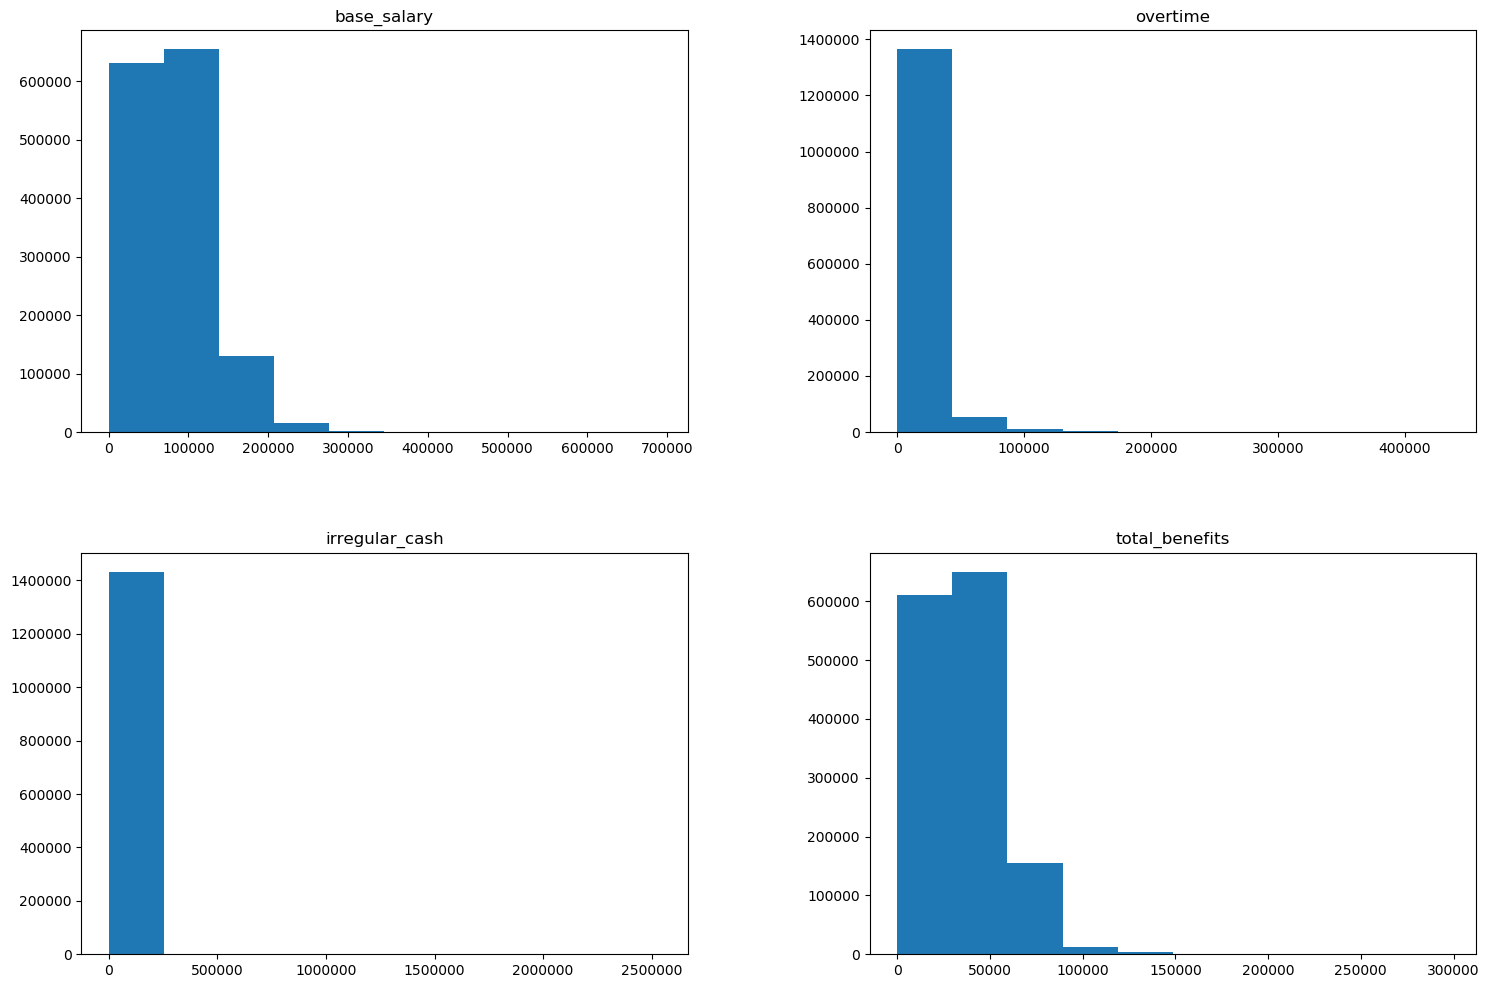

In [8]:
# histograms
df4[[ 'base_salary' , 'overtime',	'irregular_cash', 'total_benefits']].hist(grid=False, figsize=(18, 12))
plt.show()

## Modeling

In [86]:
#set predictor and target dataframes
y = df4[['total_benefits']]
X= df4.drop(['total_benefits'], axis=1)

#### train/test split

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler

# Split all data into 75% train and 25% holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=508)

# Convert target dataframe  to arrays
y_train2 = np.array(y_train)
y_test2 = np.array(y_test)

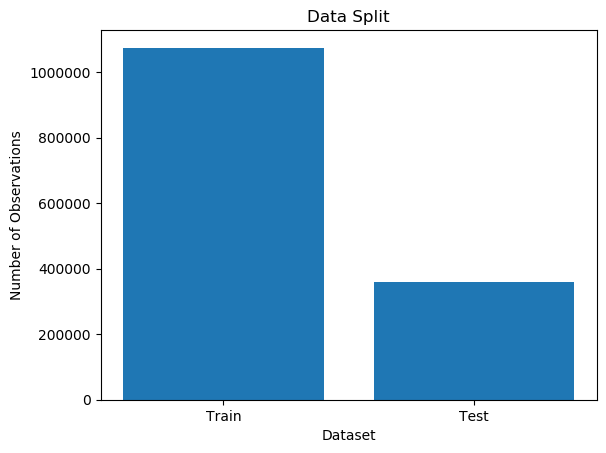

<Figure size 800x600 with 0 Axes>

In [11]:
#show train, validation and test set chart
labels = ["Train",  "Test"]
sizes = [len(X_train.index),  len(X_test.index)]

plt.bar(labels, sizes)
plt.title("Data Split")
plt.xlabel("Dataset")
plt.ylabel("Number of Observations")
plt.figure(figsize=(8, 6))
plt.show()

#### Normalize the data

In [88]:
# Select the two columns you want to transform
cols_to_transform = [ 'base_salary' , 'overtime', 'irregular_cash']

# Initialize PowerTransformer and fit on the selected columns
X_train_fit = RobustScaler().fit(X_train[cols_to_transform ])

# Transform the selected columns for both training and testing set
X_train[cols_to_transform] = X_train_fit.transform(X_train[cols_to_transform])
X_test[cols_to_transform] = X_train_fit.transform(X_test[cols_to_transform])


##### --> Other  methods such as miniscaler, min-max scaler, log transformation were also tried, not much improve in the results

In [15]:
X_train.head()

,base_salary,overtime,irregular_cash,annual_average_cpi,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,...,department_Human Services,department_IT,department_Law and Reg,"department_Libraries, Arts, Science, Museums",department_Parks,department_Police,department_Port,department_Public Works,city_id_2,city_id_3
1241779,-0.635434,-0.015092,0.007521,251.1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1396548,0.665480,-0.015092,-0.135505,236.7,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
647017,0.317651,1.297260,0.920171,258.8,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
462797,-0.539971,-0.015092,-0.262128,240.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
966941,0.698426,4.337990,2.425067,240.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [16]:
X_train.shape

(1074602, 25)

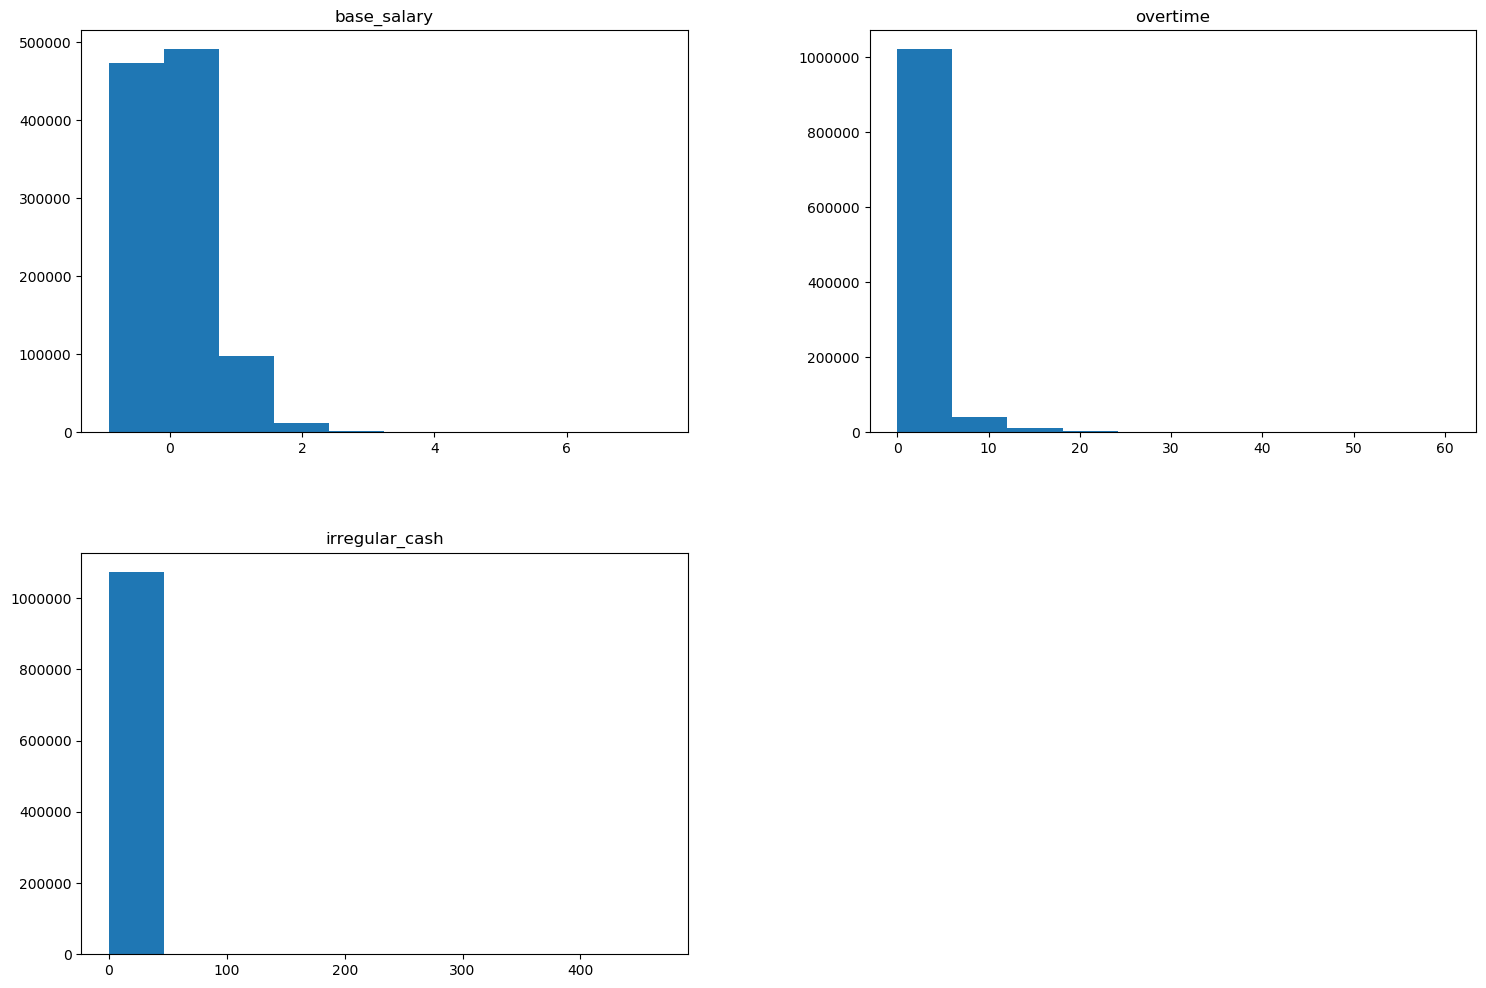

In [17]:
# histograms
X_train[[ 'base_salary' , 'overtime',	'irregular_cash']].hist(grid=False, figsize=(18, 12))
plt.show()

### Build pipeline

In [89]:
import pandas as pd
import numpy as np
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner, CategoricalParameter
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

In [92]:
from sklearn.metrics import mean_squared_error
#Define model function 
def skl_reg_model(train_x=None,
                  train_y=None,
                  val_x=None,
                  val_y=None,
                  skl_model=None,
                  grid=None,
                  cv=5):

    if grid is None:
        model_fit = skl_model.fit(train_x, train_y)
    else: 
        model_gridcv_fit = GridSearchCV(skl_model, grid, cv=cv).fit(train_x, train_y)
        model_fit = model_gridcv_fit.best_estimator_
        print(f'Best CV grid parameters for {skl_model}: {model_gridcv_fit.best_params_}')
    #performance on train set
    print('Training set')
    y_train_pred = model_fit.predict(train_x)
    print(f'RMSE = {np.sqrt(mean_squared_error(train_y, y_train_pred))}')
    print(f'R^2 score = {model_fit.score(train_x, train_y)}')
    #performance on test set
    print('Val/Test set')
    y_val_pred = model_fit.predict(val_x)
    print(f'RMSE =  {np.sqrt(mean_squared_error(val_y, y_val_pred))}')
    print(f'R^2 score = {model_fit.score(val_x, val_y)}')
    
    return model_fit

### Multiple Linear Regression

In [29]:

lr = LinearRegression()
xgb_fit = skl_reg_model(train_x=X_train,
                                 train_y=y_train2,
                                 val_x= X_test,
                                 val_y=y_test2,
                                 skl_model=lr,
                                 grid=None)

Training set
RMSE = 11262.942500672569
R^2 score = 0.7785075648636522
Val/Test set
RMSE =  11250.913003130454
R^2 score = 0.779924519366728


In [30]:
# Print the parameters (coefficients) of the model
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

Coefficients: [[ 3.11449401e+04  5.82492406e+02 -8.28762225e+02 -1.67377864e+01
   1.30217005e+03  1.05100506e+03 -2.07554781e+02 -1.37142182e+03
  -1.21041755e+03 -1.03996015e+03  9.62522728e+01  1.36949065e+03
   9.08335527e+03  1.33798498e+03  1.58862289e+03  2.34578762e+03
   7.78327829e+02  2.83590313e+03 -9.51828296e+02 -1.51662261e+03
   9.73754427e+03  4.25806004e+03 -2.55623778e+02 -4.27521374e+03
  -3.68375816e+03]]
Intercept: [38194.70557889]


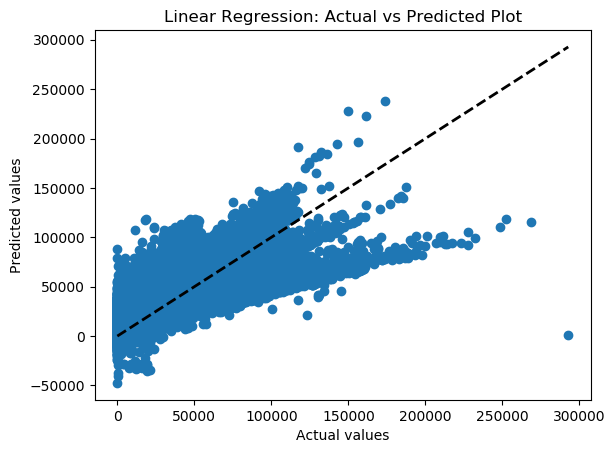

In [35]:
#Plot predicted value and the actual test data
y_val_pred = xgb_fit.predict(X_test)
plt.scatter(y_test2, y_val_pred )
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Linear Regression: Actual vs Predicted Plot')
plt.show()

### Ridge Regression

In [36]:
 #Fit a Ridge regression model
ridge = Ridge()
ridge_grid = {'alpha': [0.01, 0.1, 0.2, 0.5, 1, 10, 100]}

ridge_fit = skl_reg_model(train_x=X_train,
                                 train_y=y_train2,
                                 val_x= X_test,
                                 val_y=y_test2,
                                 skl_model=ridge,
                                 grid=ridge_grid)

Best CV grid parameters for Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001): {'alpha': 10}
Training set
RMSE = 11262.942605068081
R^2 score = 0.778507560757653
Val/Test set
RMSE =  11250.914544747788
R^2 score = 0.7799244590565649


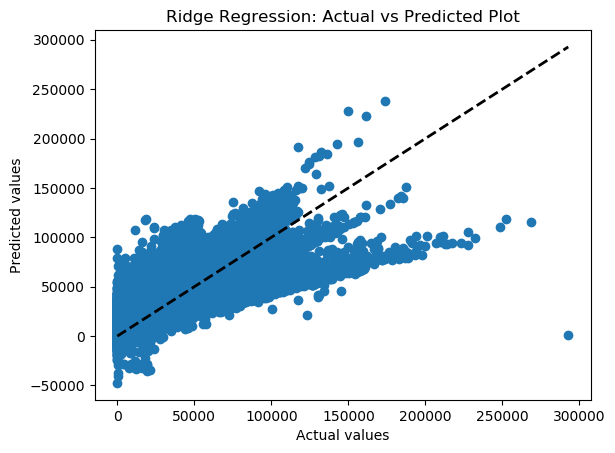

In [37]:
#Plot predicted value and the actual test data
y_val_pred = ridge_fit.predict(X_test)
plt.scatter(y_test2, y_val_pred)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Ridge Regression: Actual vs Predicted Plot')
plt.show()

### XGBoost

In [14]:
xgb = XGBRegressor(n_estimators=100)
xgb_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.5]}

xgb_fit = skl_reg_model(train_x=X_train,
                                 train_y=y_train2,
                                 val_x= X_test,
                                 val_y=y_test2,
                                 skl_model=xgb,
                                 grid=xgb_grid)

Best CV grid parameters for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:squarederror',
             predictor=None, random_state=None, reg_alpha=None, ...): {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 7}
Training set
RMSE = 6148.2111224562805
R^2 score = 0.9339986667595346
Val/Test set
RMSE =  6416.296054883127
R^2 score = 0.9284244135575569


In [39]:
best_xgb_fit = XGBRegressor(n_estimators=100, learning_rate = 0.5, max_depth=7, gamma=0). fit(X_train, y_train2)
y_val_pred = best_xgb_fit.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test2, y_val_pred))

In [40]:
rmse 

6416.296054883127

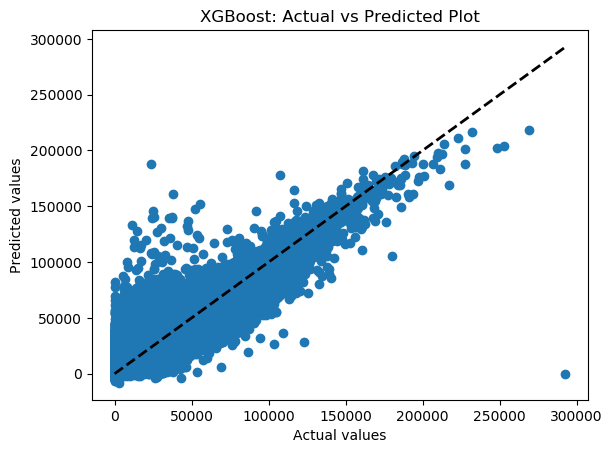

In [41]:
#Plot predicted value and the actual test data
y_val_pred = best_xgb_fit.predict(X_test)
plt.scatter(y_test2, y_val_pred)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('XGBoost: Actual vs Predicted Plot')
plt.show()

### Random Forest

In [93]:
#Random forest with tuning
rf = RandomForestRegressor(n_estimators=300)
rf_grid = { 'max_depth': [3,5,7]}

rf_fit = skl_reg_model(train_x=X_train,
                                 train_y=y_train2,
                                 val_x= X_test,
                                 val_y=y_test2,
                                 skl_model=rf,
                                 grid=rf_grid)

Best CV grid parameters for RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False): {'max_depth': 7}
Training set
RMSE = 8955.297361353529
R^2 score = 0.8599719031158484
Val/Test set
RMSE =  8972.501920955461
R^2 score = 0.8600337761649571


In [96]:
rf_fit = XGBRegressor(n_estimators=300, max_depth=7). fit(X_train, y_train2)
y_val_pred = rf_fit.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test2, y_val_pred))

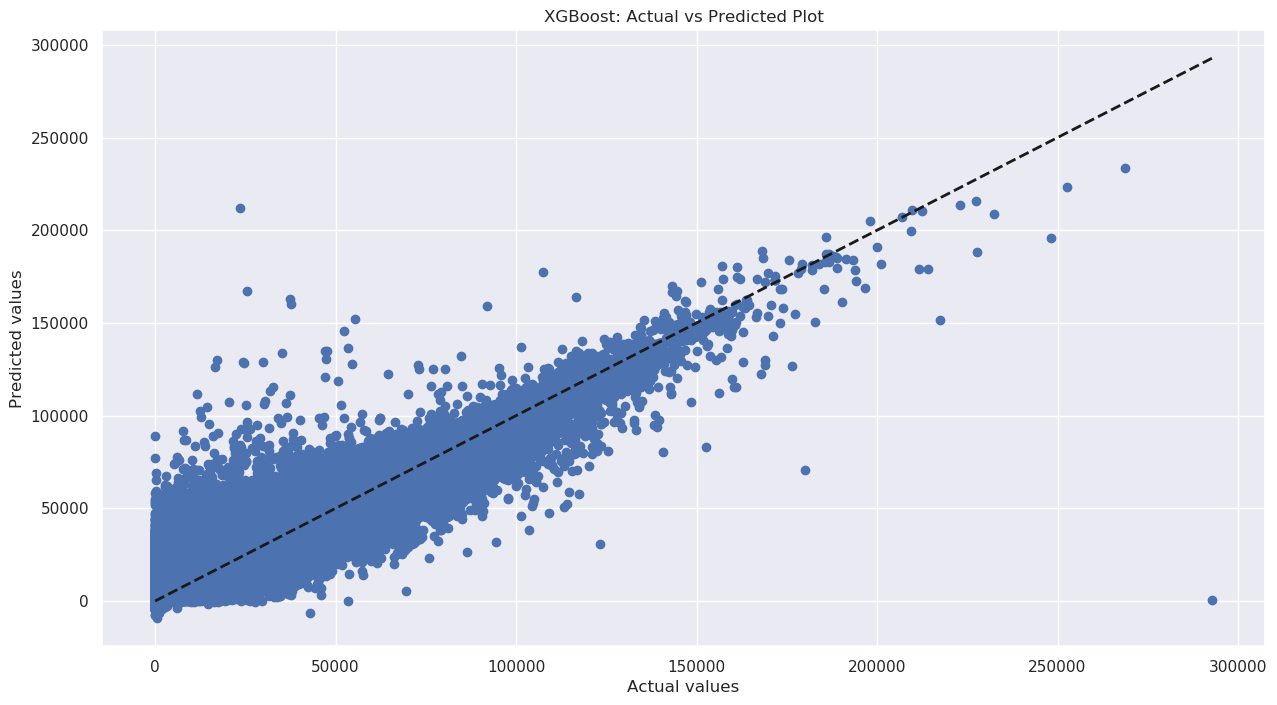

In [97]:
#Plot predicted value and the actual test data
y_val_pred = rf_fit.predict(X_test)
plt.scatter(y_test2, y_val_pred)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('XGBoost: Actual vs Predicted Plot')
plt.show()

#### Learner curve plot 

In [85]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt


title = "Learning Curve (Random Forest Regressor)"
cv = 5 # number of cross-validation folds
plot_learning_curve(rf, title, X_train2, y_train2.ravel(), cv=cv)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

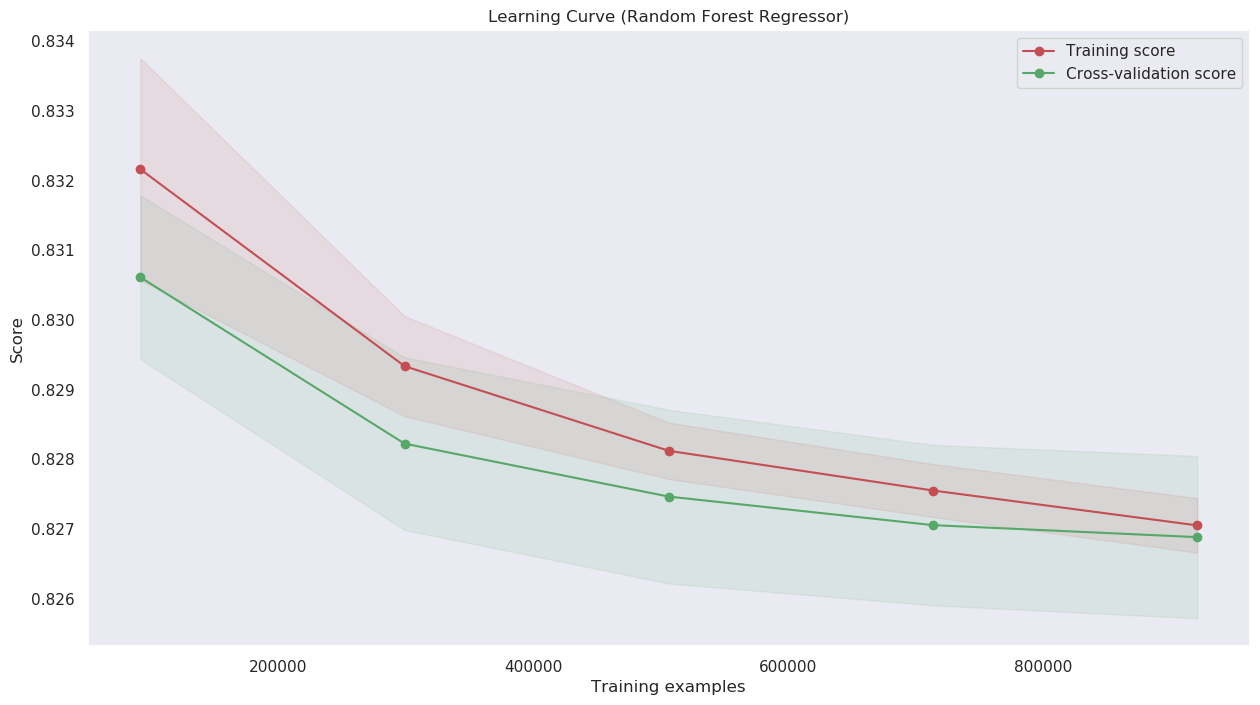

In [86]:
plt.show()

#### Feature importance

##### --> Training result seems to not much improve after the sample size reach around 500K-600K instances

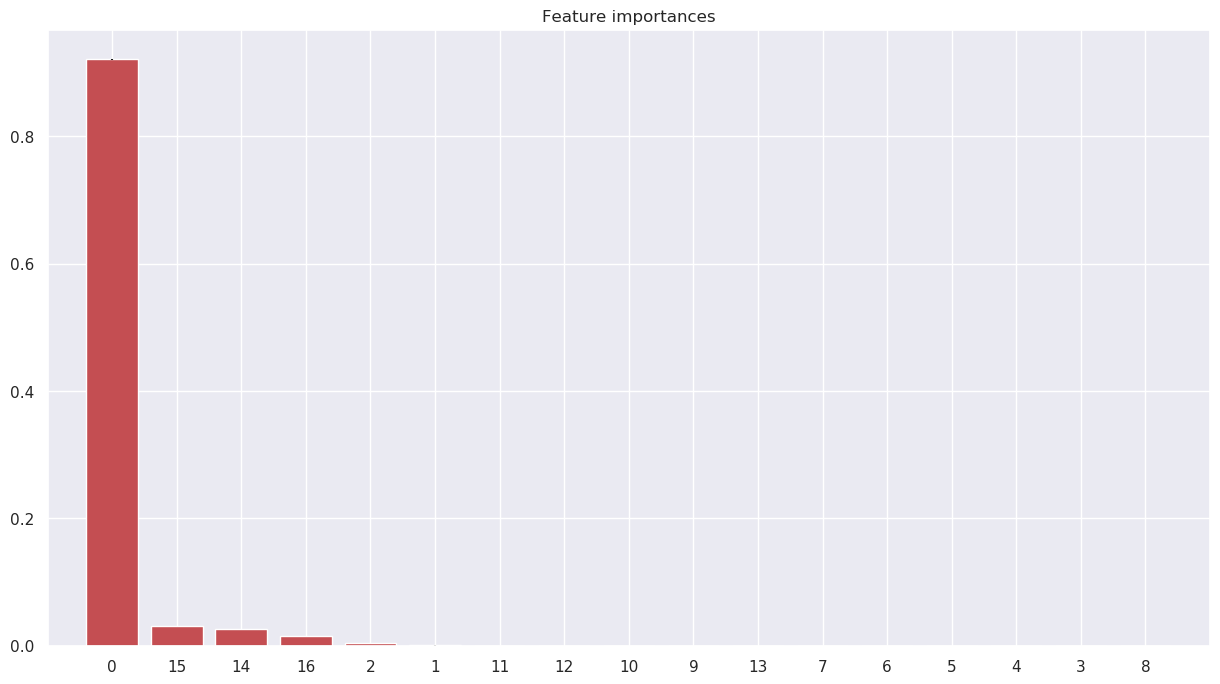

In [87]:
#Feature importance
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# # train a Random Forest Regressor model
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# plot feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

##### --> Base_salary showed to be the most important feature. In fact, it is explain more than 90% of the results.

#### Examine the base_salary alone in the training 

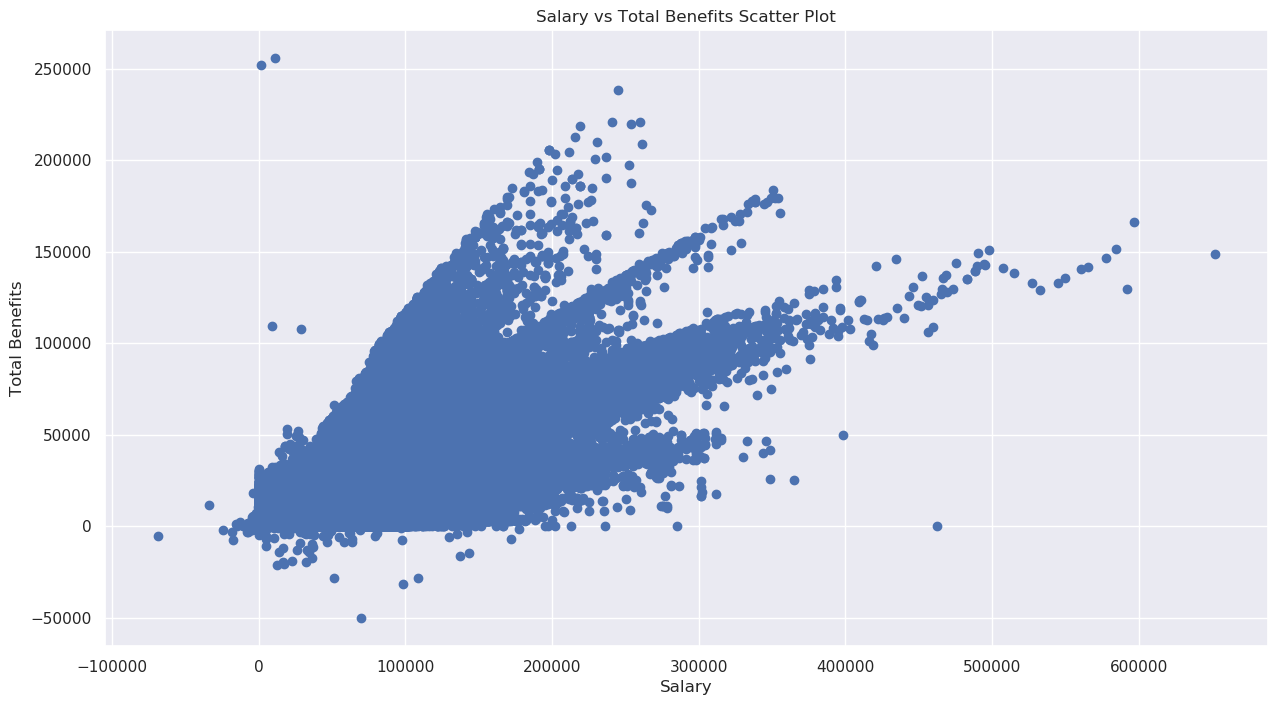

In [112]:
# Create the scatter plot
plt.scatter(df4['base_salary'], df4['total_benefits'])
plt.xlabel('Salary')
plt.ylabel('Total Benefits')
plt.title('Salary vs Total Benefits Scatter Plot')
plt.show()

In [100]:
#Linear regression 
lr2= LinearRegression().fit(np.array(X_train['base_salary']).reshape(-1, 1), y_train2)

In [101]:
# make predictions on the test data
y_pred = lr2.predict(np.array(X_test['base_salary']).reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test2, y_pred))

In [103]:
# calculate the RMSE between the predicted and true values
#rmse = np.sqrt(mean_squared_error(y_val2, y_pred))
mae = mean_absolute_error(y_test2, y_pred)
mae

7899.037006717493

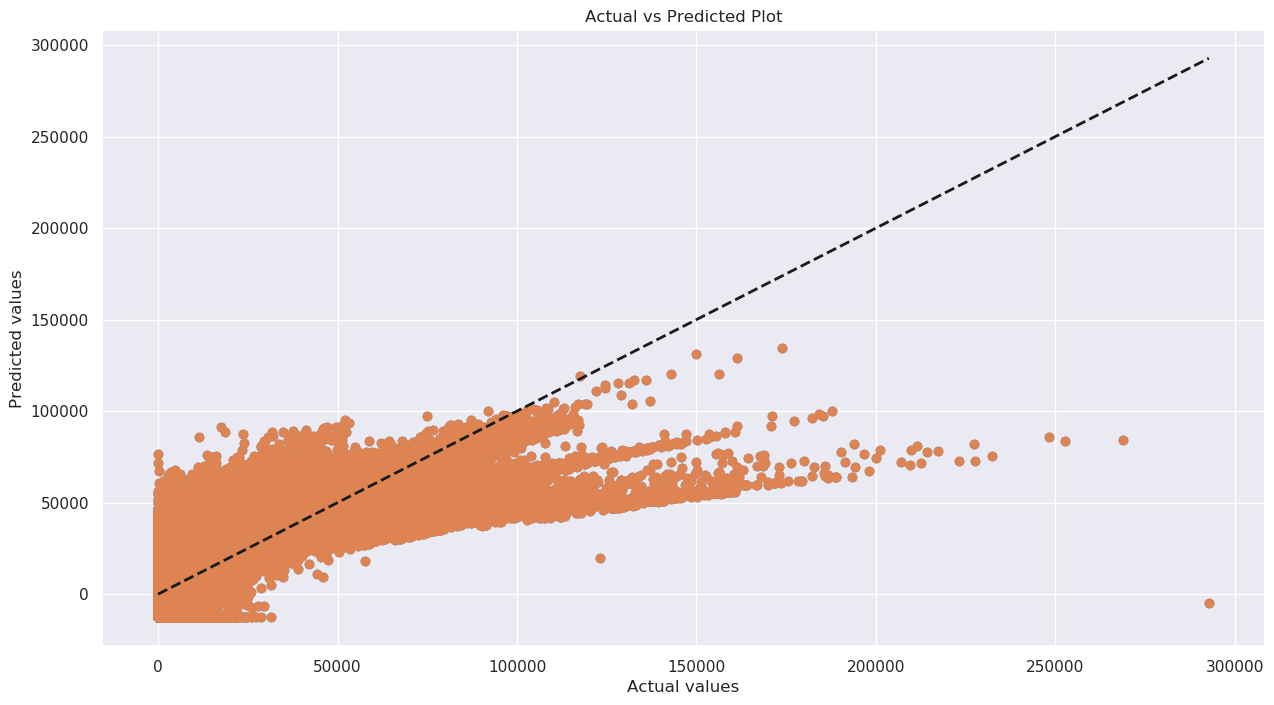

In [105]:
plt.scatter(y_test2, y_pred)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted Plot')
plt.show()

##### --> model run on only base_salary feature can predict most of the target. Other features seem to be not very useful. In the future, more feature need to be explore. Job_title could be a great one if we could manage to condense values into relevant groups. 

#### Shutting down your kernel for this notebook to release resources.

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

#### Shutting down all checkpoint and kernels for all notebooks 

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}